# Trait Simulation Tutorial

Authors: Sarah Ji, Janet Sinsheimer, Kenneth Lange

In this notebook we show how to use the `TraitSimulation.jl` package we illustrate how TraitSimulation.jl can easily simulate traits from genotype data, all within the OpenMendel universe. Operating within this universe brings potential advantages over the available software(s) when needed for downstream analysis or study design. 

Using just a few calls on the command line to the appropriate packages within the OpenMendel, we demonstrate in three easy examples the utilities of the TraitSimulation.jl package.


## Background

There is a lack of software available to geneticists who wish to calculate power and sample sizes in designing a study on genetics data. Typically, the study power depends on assumptions about the underlying disease model.  Many power calculating software tools operate as a black box and do not allow for customization.  To develop custom tests, researchers can develop their own simulation procedures to carry out power calculations.  One limitation with many existing methods for simulating traits conditional on genotypes is that these methods are limited to normally distributed traits and to fixed effects. 

This software package, TraitSimuliation.jl addresses the need for simulated trait data in genetic analyses.  This package generates data sets that will allow researchers to accurately check the validity of programs and to calculate power for their proposed studies. This package gives users the ability to easily simulate phenotypic traits under GLMs or LMMs conditional on PLINK formatted genotype data [3]. In addition, we include customized simulation utilities that accompany specific genetic analysis options in Open-Mendel; for example, ordered, multinomial traits. We demonstrate these simulation utilities on the example dataset described below.


## Demonstration

##### Example Data

We use the OpenMendel package [SnpArrays.jl](https://openmendel.github.io/SnpArrays.jl/latest/) to both read in and write out PLINK formatted files. Available in the data directory under the [Example_Data](https://openmendel.github.io/SnpArrays.jl/latest/#Example-data-1) section of this package, we use the file `"EUR_SUBSET"` for the demonstration how to simulate phenotypic traits on PLINK formatted data. 
For convenience we use the common assumption that the residual covariance among two relatives can be captured by the additive genetic variance times twice the kinship coefficient.

In each example the user can specify the simulation model parameters, along with the number of repitions for each simulation model as desired. By default, the simulation will return the result of a single simulation.


### Double check that you are using Julia version 1.0 or higher by checking the machine information

In [1]:
versioninfo()

Julia Version 1.2.0
Commit c6da87ff4b (2019-08-20 00:03 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.6.0)
  CPU: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, skylake)


In [2]:
using Revise, Plots
using DataFrames, LinearAlgebra, Random, SnpArrays, Distributions, TraitSimulation, BenchmarkTools, StatsBase, GLM, OrdinalMultinomialModels
Random.seed!(1234);

┌ Info: Recompiling stale cache file /Users/sarahji/.julia/compiled/v1.2/Revise/M1Qoh.ji for Revise [295af30f-e4ad-537b-8983-00126c2a3abe]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/sarahji/.julia/compiled/v1.2/TraitSimulation/VikWX.ji for TraitSimulation [dec3038e-29bc-11e9-2207-9f3d5855a202]
└ @ Base loading.jl:1240


# Reading genotype data using SnpArrays

First use `SnpArrays.jl` to read in the genotype data. We use PLINK formatted data with the same prefixes for the .bim, .fam, .bed files.

SnpArrays is a very useful utility and can do a lot more than just read in the data. More information about all the functionality of SnpArrays can be found at:
https://openmendel.github.io/SnpArrays.jl/latest/

As missing genotypes are often due to problems making the calls, the called genotypes at a marker with too much missing genotypes are potentially unreliable. By default, SnpArrays filters to keep only the genotypes with success rates greater than 0.98 and the minimum minor allele frequency to be 0.01. If the user wishes to change the stringency, she should change the number given in filter according to https://openmendel.github.io/SnpArrays.jl/latest/#Fitering-1.

In [3]:
filename = "EUR_subset"
EUR = SnpArray(SnpArrays.datadir(filename * ".bed"));

In [4]:
rowmask, colmask =  SnpArrays.filter(EUR)
minor_allele_frequency = maf(EUR);
# rows are people; columns are SNPs
people, snps = size(EUR)

(379, 54051)

In [5]:
EUR_data = SnpData(SnpArrays.datadir(filename));

Here we will use the rarest snp in our dataset, rs150018646, as the causal snp in our model for demonstration. Additionally, we will control for sex, with females as the baseline group, `sex = 0.0`. We want to find the index of this causal locus in the snp_definition (.bim) file and then subset that locus from the genetic marker data above. 

For users who wish to identify by name, which locus to include, first subset the names of all the loci into a vector called `snpid`  and then call the following command to store our design matrix for the model that includes sex and locus of choice. 

`snpid  = bimfile[!, :snpid]`

`causal_snp_index = findall(x -> x == "rs150018646", snpid)` 

To comform to common convention we also transform sex variable from M/F to 1/0. 

In [6]:
bimfile = EUR_data.snp_info
causal_snp_index = findmin(minor_allele_frequency)[2]
locus = convert(Vector{Float64}, @view(EUR[:, causal_snp_index]))

famfile = EUR_data.person_info
sex = map(x -> strip(x) == "F" ? 0.0 : 1.0, famfile[!, :sex]) # note julia's ternary operator '?'
X = DataFrame(intercept = ones(length(sex)), sex = sex, locus = locus)

,intercept,sex,locus
,Float64,Float64,Float64
1,1.0,1.0,2.0
2,1.0,1.0,1.0
3,1.0,1.0,2.0
4,1.0,1.0,2.0
5,1.0,1.0,2.0
6,1.0,1.0,2.0
7,1.0,1.0,2.0
8,1.0,1.0,2.0
9,1.0,1.0,2.0


# Example 1: Standard Models

In this example we first demonstrate how to use the GLM.jl package to simulate a trait from unrelated individuals. We then show how to use our TraitSimulation.jl package to simulate a trait from families.  

The notebook is organized as follows:
    
$\textbf{Example 1: Standard Models}$

For the first example, we show how to simulate traits from standard models users in the genetics community will recognize. 

Users can specify to simulate phenotypes from unrelateds or families with user-specified Generalized Linear Models (GLMs) or Linear Mixed Models (LMMs), respectively. Researchers who feel more comfortable viewing the latter as a Variance Component Model(VCM) an additive genetic variance component and environmental variance component, we welcome you to do so. 

$$ 1 . \text{GLM}: Y_{n \times 1} \sim \text{Poisson}(\mathbf{\mu}_{n \times 1} = g^{-1}{(XB)}, \Sigma_{n \times n} = \sigma_A \times \Phi + \sigma_E \times I_n) $$

$$ 2 . \text{LMM/VCM}: Y_{n \times p} \sim \text{MatrixNormal}(\mathbf{M}_{n \times p} = XB, \Omega_{np \times np} = \Sigma_A \otimes \Phi + \Sigma_E \otimes I_n)$$

We show in the next example, models with additional variance components can also be specified, as long as they are sensible (positive semi definite).

## GLM Traits from Unrelated Individuals
$$
    Y ∼ Poisson(μ = X\beta)
$$ 

Here we specify the fixed effects and the phenotype distribution, and output for ten simulations per person. 

In [7]:
β = [1; 0.2; 0.5]
mu = Matrix(X) * β
dist = Poisson
GLMmodel = GLMTrait(mu, dist);
Simulated_GLM_Traits = DataFrame(PoissonTrait = simulate(GLMmodel))

,PoissonTrait
,Int64
1,10
2,7
3,9
4,9
5,11
6,12
7,6
8,7
9,7


## Rare Variant LMM Related Individuals

In this example we show how to generate data so that the related individuals have correlated trait values even after we account for the effect of a snp, a combination of snps or other fixed effects. We simulate data under a linear mixed model so that we can model residual dependency among individuals. 

$$
Y ∼ N(\mu, 4* 2GRM + 2I)
$$

This example is meant to simulate data in a scenario in which a number of rare mutations in a single gene can change a trait value. We model the residual variation among relatives with the additive genetic variance component and we include 20 rare variants in the mean portion of the model, defined as loci with minor allele frequencies greater than 0.002 but less than 0.02.

Specifically we are generating a single normal trait controlling for family structure with residual heritabiity of 67%, and effect sizes for the variants generated as a function of the minor allele frequencies. The rarer the variant the greater its effect size.

In practice rare variants have smaller minor allele frequencies, but we are limited in this tutorial by the relatively small size of the data set. Note also that our modeling these effects as part of the mean is not meant to imply that the best way to detect them would be a standard association analysis. Instead we recommend a burden or SKAT test.

In [8]:
GRM = grm(EUR, minmaf = 0.05);

## Filtering

We first subset only the rare SNP's, then we simulate traits on the 20 of the rare SNP's. For this demo, we subset the fist k = 20 rare snps. Change the parameters and the number of SNPs for simulation to model different regions of the genome. The number 20 is arbitrary and you can use more or less than 20 if you desire by changing the final number.

In [9]:
# filter out rare SNPS, get a subset of uncommon SNPs with 0.002 < MAF ≤ 0.02
minor_allele_frequency = maf(EUR)
rare_index = (0.002 .< minor_allele_frequency .≤ 0.02)
filtsnpdata = SnpArrays.filter(EUR_data, rowmask, rare_index, des = "rare_filtered_28data");

In [10]:
rare_snps = SnpArray("rare_filtered_28data.bed");

### Simulation

For demonstration purposes, we simulate effect sizes from the Chi-squared(df = 1) distribution, where we use the minor allele frequency (maf) as x and find f(x) where f is the pdf for the Chi-squared (df = 1) density, so that the rarest SNP's have the biggest effect sizes. The effect sizes are rounded to the second digit, throughout this example. Notice there is a random +1 or -1, so that there are effects that both increase and decrease the simulated trait value.

```julia

# Generating Effect Sizes from Chisquared(df = 1) density

n = length(rare_snps)
chisq_coeff = zeros(n)

for i in 1:n
    chisq_coeff[i] = rand([-1, 1]) .* (0.1 / sqrt.(maf_rare_snps[i] .* (1 - maf_rare_snps[i])))
end
```

In [11]:
effsizes = simulate_effect_size(minor_allele_frequency[rare_index][1:20])
X_rare = rare_snps[:, 1:20]
mu = Matrix(X_rare) * effsizes
rare_20_snp_model = LMMTrait(mu[:, :], 4*(2*GRM) + 2*(I))
trait_rare_20_snps = DataFrame(SimTrait = simulate(rare_20_snp_model)[:])

,SimTrait
,Float64
1,3.49578
2,3.07411
3,6.29971
4,12.0832
5,6.64243
6,7.04278
7,7.12708
8,5.55116
9,3.29359


In [12]:
rm("rare_filtered_28data.bed")
rm("rare_filtered_28data.bim")
rm("rare_filtered_28data.fam")

# Example 2: Multiple Traits, Multiple Variance Components? Easy.


$\textbf{Example 2: M > 2 Variance Components? Easy.}$

This example extends the linear mixed model in the previous example to demo how to efficiently account for any number of other random effects, in addition to the additive genetic and environmental variance components. In this example we show alternative ways to specify the simulation parameters for the LMM/VCM and benchmark it against the available MatrixNormal distribution in Julia package, Distributions.jl.

$$Y_{n \times p} \sim \text{MatrixNormal}(\mathbf{M}_{n \times p} = XB, \Omega_{np \times np} = \sum_{k=1}^m \Sigma_k \otimes V_k)$$

Say that you have the the classical setting in genetics, two variance components, one for the additive genetic variance and one for the environmental variance. 

Users can specify their covariance structures as follows. We note that this form can also accompany more than 2 variance components. 

In [13]:
formulas = ["1 + 2.0*sex + 0.5*locus", "20 + 2.0*sex + 1.0*locus"]
I_n = Matrix{Float64}(I, size(GRM))
V_A = [4 1; 1 4]
V_E = [2.0 0.0; 0.0 2.0];

# @vc is a macro that creates a 'VarianceComponent' Type for simulation
variance_formula = @vc V_A ⊗ 2GRM + V_E ⊗ I_n;

In [14]:
X

,intercept,sex,locus
,Float64,Float64,Float64
1,1.0,1.0,2.0
2,1.0,1.0,1.0
3,1.0,1.0,2.0
4,1.0,1.0,2.0
5,1.0,1.0,2.0
6,1.0,1.0,2.0
7,1.0,1.0,2.0
8,1.0,1.0,2.0
9,1.0,1.0,2.0


In [15]:
genetic_model = LMMTrait(formulas, X, variance_formula)
simulate(genetic_model)

379×2 Array{Float64,2}:
  2.91272   16.855 
  6.47788   22.6709
  6.28548   22.1494
  1.68611   23.9102
  6.21815   21.9615
  0.775005  22.8052
  6.92803   25.2613
  4.65273   22.0473
  5.70771   26.3672
  5.36878   24.0772
  5.28921   27.3522
  6.83123   27.4631
  1.37503   25.5119
  ⋮                
  2.83931   26.3809
  6.16545   25.392 
  3.61415   19.5572
  5.51532   30.2318
 -0.712072  22.7384
  4.3396    24.9106
  0.721891  24.7025
  5.27661   22.5513
  9.57922   24.9344
  5.10513   22.517 
  7.3557    26.0108
  3.7574    23.7958

## Benchmarking against Julia

Here for m = 10 random Variance Components, we generate m random covariance matrices, a random design matrix and p regression coefficients to illustrate the simulation of a d = 2 dimensional response matrix of traits for a sample of n = 1000 people. 

We then benchmark against the same simulation process using the MatrixNormal() function in the Distributions.jl package. 

    function generateSPDmatrix(n)
        A = rand(n)
        m = 0.5 * (A * A')
        PDmat = m + (n * Diagonal(ones(n)))
    end


    function generateRandomVCM(n::Int64, p::Int64, d::Int64, m::Int64)
        # n-by-p design matrix
        X = randn(n, p)

        # p-by-d mean component regression coefficient for each trait
        B = hcat(ones(p, 1), rand(p))  

        V = ntuple(x -> zeros(n, n), m) 
        for i = 1:m-1
          copy!(V[i], generateSPDmatrix(n))
        end
        copy!(V[end], Diagonal(ones(n))) # last covarianec matrix is identity

        # a tuple of m d-by-d variance component parameters
        Σ = ntuple(x -> zeros(d, d), m) 
        for i in 1:m
          copy!(Σ[i], generateSPDmatrix(d))
        end

        return(X, B, Σ, V)
    end


In [16]:
n = 379   # no. observations
d = 2      # dimension of responses
m = 10      # no. variance components
p = 2;      # no. covariates

In [17]:
X_sim, B_sim, Σ_sim, V_sim = generateRandomVCM(n, p, d, m);
Random_VCM_Trait = DataFrame(LMM_trait_simulation(X_sim, B_sim, Σ_sim, V_sim), [:SimTrait1, :SimTrait2])

,SimTrait1,SimTrait2
,Float64,Float64
1,201.289,-57.8455
2,-30.4242,-15.2018
3,200.725,154.022
4,94.3728,-54.2853
5,-48.6075,17.684
6,38.2245,167.131
7,88.3336,-97.9209
8,-38.276,-1.67935
9,-9.06548,6.77236


In our VarianceComponent type, we store the cholesky decomposition of each $\Sigma_i$ and $V_i$, computed outside of simulation within the vc_vector of VarianceComponent types. This is important since the more often than not, users have to run the simulation many times for their desired goal. 

From our benchmarking below, we show that when we use the simulation package to simulate traits n_reps times, using the VariaceComponent type is much faster and memory efficient than calling the available julia MatrixNormal distribution m times. 

## Compare simulation for m = 1 variance component

For only one variance component we are roughly four 2x more memory efficient and 3.7x faster at simulating this bivariate trait

In [18]:
LMMtraitobj = LMMTrait(X_sim*B_sim, VarianceComponent(Σ_sim[1], V_sim[1]))
@benchmark simulate(LMMtraitobj)

BenchmarkTools.Trial: 
  memory estimate:  1.11 MiB
  allocs estimate:  4
  --------------
  minimum time:     237.055 μs (0.00% GC)
  median time:      297.830 μs (0.00% GC)
  mean time:        512.769 μs (20.59% GC)
  maximum time:     5.741 ms (77.12% GC)
  --------------
  samples:          9666
  evals/sample:     1

In [19]:
function MN_J(X, B, Σ, V; n_reps = 1)
    n, p = size(X*B)
    sim = [zeros(n, p) for i in 1:n_reps]
    for i in 1:n_reps
        sim[i] = rand(MatrixNormal(X*B, V, Σ))
    end
    return(sim)
end

@benchmark MN_J($X_sim, $B_sim, $Σ_sim[1], $V_sim[1])

BenchmarkTools.Trial: 
  memory estimate:  2.24 MiB
  allocs estimate:  25
  --------------
  minimum time:     986.931 μs (0.00% GC)
  median time:      1.121 ms (0.00% GC)
  mean time:        1.523 ms (13.34% GC)
  maximum time:     6.378 ms (38.78% GC)
  --------------
  samples:          3264
  evals/sample:     1

## Compare simulation for m = 10 variance components

still about 2x memory efficient but now 3.2x faster compared to the Distributions package

In [20]:
vc_vector = [VarianceComponent(Σ_sim[i], V_sim[i]) for i in eachindex(V_sim)]
LMMtraitobjm = LMMTrait(X_sim*B_sim, vc_vector);
@benchmark simulate(LMMtraitobjm)

BenchmarkTools.Trial: 
  memory estimate:  10.98 MiB
  allocs estimate:  23
  --------------
  minimum time:     3.021 ms (0.00% GC)
  median time:      6.274 ms (14.95% GC)
  mean time:        5.434 ms (19.08% GC)
  maximum time:     9.107 ms (23.71% GC)
  --------------
  samples:          918
  evals/sample:     1

In [21]:
function MN_Jm(X, B, Σ, V; n_reps = 1)
    n, p = size(X*B)
    m = length(V)
    sim = [zeros(n, p) for i in 1:n_reps]
    for i in 1:n_reps
        for j in 1:m
            dist = MatrixNormal(X*B, V[j], Σ[j])
            sim[i] += rand(dist)
        end
    end
    return(sim)
end

@benchmark vecs = MN_Jm($X_sim, $B_sim, $Σ_sim, $V_sim)

BenchmarkTools.Trial: 
  memory estimate:  22.35 MiB
  allocs estimate:  233
  --------------
  minimum time:     14.524 ms (14.65% GC)
  median time:      15.335 ms (14.09% GC)
  mean time:        16.857 ms (13.55% GC)
  maximum time:     30.225 ms (11.75% GC)
  --------------
  samples:          297
  evals/sample:     1

# Example 3: Power Calculation

$\textbf{Example 3: Custom Models- Power Demonstration}$

For the last example, we show how to simulate from customized simulation models that accompany specific genetic analysis options in Open-Mendel; for example, ordered, multinomial traits. This example illustrates the use of the simulations to generates data sets allowing researchers to accurately check the validity of programs and to calculate power for their proposed studies.


## Genotype Simulation:

a) genotype simulation utilities under HWE

We use the minor allele frequency of the causal variant to simulate the SnpArray.

In [22]:
maf_causal_snp = [0.2]
Simulated_SnpArray = snparray_simulation(maf_causal_snp, n)

379×1 SnpArray:
 0x00
 0x02
 0x00
 0x00
 0x02
 0x02
 0x00
 0x00
 0x00
 0x02
 0x00
 0x02
 0x00
    ⋮
 0x00
 0x00
 0x00
 0x00
 0x00
 0x00
 0x00
 0x02
 0x00
 0x00
 0x02
 0x00

In [23]:
locus = convert(Vector{Float64}, @view(Simulated_SnpArray[:, 1]))

379-element Array{Float64,1}:
 0.0
 1.0
 0.0
 0.0
 1.0
 1.0
 0.0
 0.0
 0.0
 1.0
 0.0
 1.0
 0.0
 ⋮  
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 1.0
 0.0

In [24]:
pdf_sex = Bernoulli(0.51)
pdf_age = Normal(45, 8)

sex = rand(pdf_sex, n)
age = zscore(rand(pdf_age, n))

X_new = [age sex locus]

379×3 Array{Float64,2}:
  0.407127   0.0  0.0
 -0.558203   1.0  1.0
 -1.12104    0.0  0.0
  0.45187    1.0  0.0
 -1.8414     1.0  1.0
  1.1218     1.0  1.0
 -0.625564   0.0  0.0
 -0.0349323  1.0  0.0
  0.586154   0.0  0.0
  1.07314    1.0  1.0
  0.131521   1.0  0.0
 -1.1149     1.0  1.0
  0.403265   0.0  0.0
  ⋮                  
  2.29484    0.0  0.0
 -0.234866   1.0  0.0
  0.663314   1.0  0.0
  0.907418   1.0  0.0
 -0.854223   0.0  0.0
 -0.618171   1.0  0.0
  0.0584837  0.0  0.0
 -0.21188    1.0  1.0
  0.762782   1.0  0.0
 -0.841109   1.0  0.0
  0.877906   1.0  1.0
 -1.5609     0.0  0.0

## Phenotype Simulation:
b) phenotype simulation conditional on simulated genotypes

### Ordered Multinomial Trait

In [25]:
θ = [1.0, 1.2, 1.4]
β_new = [1.0, 2.0, 10.0]
Ordinal_Model = OrdinalTrait(X_new, β_new, θ, LogitLink())

OrdinalTrait{Float64,LogitLink}([0.4071271462021118 0.0 0.0; -0.5582027968010086 1.0 1.0; … ; 0.8779062782252005 1.0 1.0; -1.5609003032306286 0.0 0.0], [1.0, 2.0, 10.0], [1.0, 1.2, 1.4], LogitLink())

In [26]:
Ordinal_Trait = simulate(Ordinal_Model)

379-element Array{Int64,1}:
 1
 4
 1
 4
 4
 4
 1
 1
 1
 4
 4
 4
 1
 ⋮
 1
 1
 4
 4
 1
 4
 4
 4
 4
 4
 4
 1

### Simulate Ordered Multinomial Logistic

In [27]:
Logistic_Trait = simulate(Ordinal_Model, Logistic = true, threshold = 2)

379-element Array{Int64,1}:
 0
 1
 1
 1
 1
 1
 0
 0
 0
 1
 0
 1
 0
 ⋮
 1
 1
 0
 0
 0
 0
 0
 1
 1
 1
 1
 1

### Power Calculation:

We use the following function to generate the p-values for the simulated power example for the logistic vs linear regression model. We include plots of different power/effect size combinations for Ordered Logistic Regression models 
    

In [28]:
γs = collect(0.0:0.05:0.5)

11-element Array{Float64,1}:
 0.0 
 0.05
 0.1 
 0.15
 0.2 
 0.25
 0.3 
 0.35
 0.4 
 0.45
 0.5 

In [29]:
P = realistic_power_simulation(1000, γs, Ordinal_Model, 1234)

1000×11 Array{Float64,2}:
 0.98821    0.677405    0.750923   0.0035454  …  0.00125706  0.00806858 
 0.753635   0.0544803   0.995895   0.626111      0.00106554  0.00668177 
 0.0567127  0.132338    0.639366   0.868032      0.0609115   0.0436389  
 0.421616   0.852874    0.719334   0.972179      0.0368512   0.000209448
 0.904168   0.965509    0.192946   0.0886994     0.0316606   0.0205866  
 0.510296   0.798285    0.802923   0.827623   …  0.0176615   0.394335   
 0.238666   0.662985    0.0841425  0.646225      0.0430174   0.0363795  
 0.44257    0.800534    0.0951966  0.24411       0.1619      0.175332   
 0.97319    0.0514531   0.406705   0.0977883     0.100182    0.249145   
 0.766394   0.399194    0.514458   0.91565       0.0127169   0.385098   
 0.94113    0.233683    0.504514   0.213161   …  0.503449    0.00322882 
 0.277928   0.203745    0.269898   0.0492218     0.0127707   0.0117821  
 0.803519   0.53307     0.120443   0.0782337     0.0570739   0.00909654 
 ⋮                       

In [30]:
power_ES = power(P, 0.05)

11-element Array{Float64,1}:
 0.045
 0.052
 0.078
 0.116
 0.131
 0.234
 0.256
 0.349
 0.42 
 0.513
 0.618

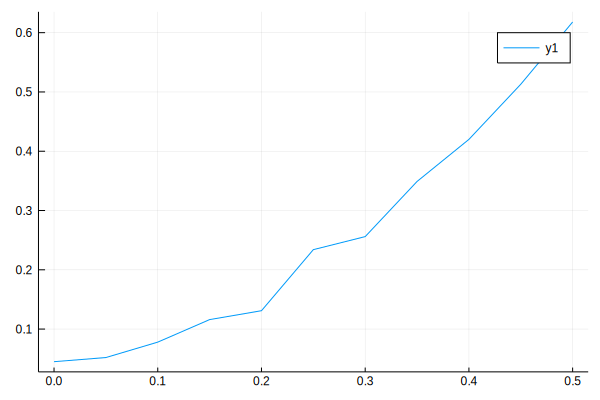

In [31]:
plot(γs, power_ES)

## Citations: 

[1] Lange K, Papp JC, Sinsheimer JS, Sripracha R, Zhou H, Sobel EM (2013) Mendel: The Swiss army knife of genetic analysis programs. Bioinformatics 29:1568-1570.`


[2] OPENMENDEL: a cooperative programming project for statistical genetics.
[Hum Genet. 2019 Mar 26. doi: 10.1007/s00439-019-02001-z](https://www.ncbi.nlm.nih.gov/pubmed/?term=OPENMENDEL).
